In [1]:
# -*- coding: utf-8 -*-
#   This work is part of the Core Imaging Library (CIL) developed by CCPi 
#   (Collaborative Computational Project in Tomographic Imaging), with 
#   substantial contributions by UKRI-STFC and University of Manchester.

#   Licensed under the Apache License, Version 2.0 (the "License");
#   you may not use this file except in compliance with the License.
#   You may obtain a copy of the License at

#   http://www.apache.org/licenses/LICENSE-2.0

#   Unless required by applicable law or agreed to in writing, software
#   distributed under the License is distributed on an "AS IS" BASIS,
#   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#   See the License for the specific language governing permissions and
#   limitations under the License.

#   Copyright 2021 UKRI-STFC
#   Authored by: Evangelos Papoutsellis (UKRI-STFC)
#                Gemma Fardell (UKRI-STFC)

<h1><center>Colour Processing </center></h1>

In this notebook, we present how to **denoise** and **inpaint** our first **multichannel** data using CIL, i.e., a data with only 3 channels that contains information from the **Red**, **Green** and **Blue** bands. We start by loading a colour image from CIL.

In [2]:
# import dataexample that contains different colour images
from cil.utilities import dataexample, noise

# import other libraries
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from cil.utilities.display import show2D
import numpy as np

In [3]:
# Load Rainbow image

data = dataexample.RAINBOW.get(size=(500,500), scale=(0,1))
data.reorder(['horizontal_y', 'horizontal_x','channel'])

## Show colour image and RGB channels

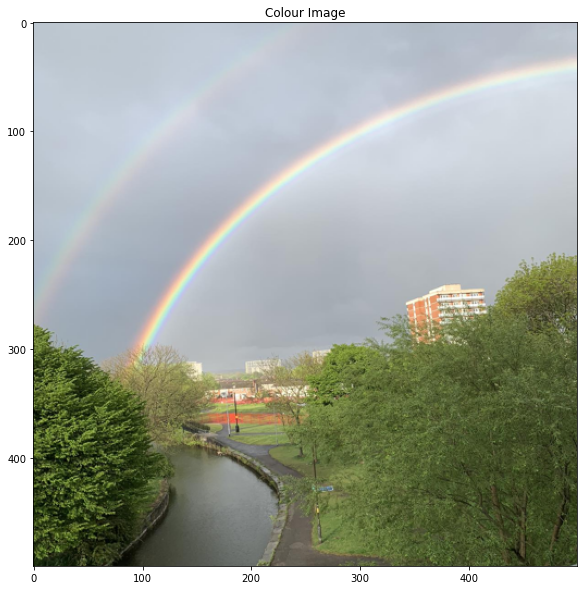

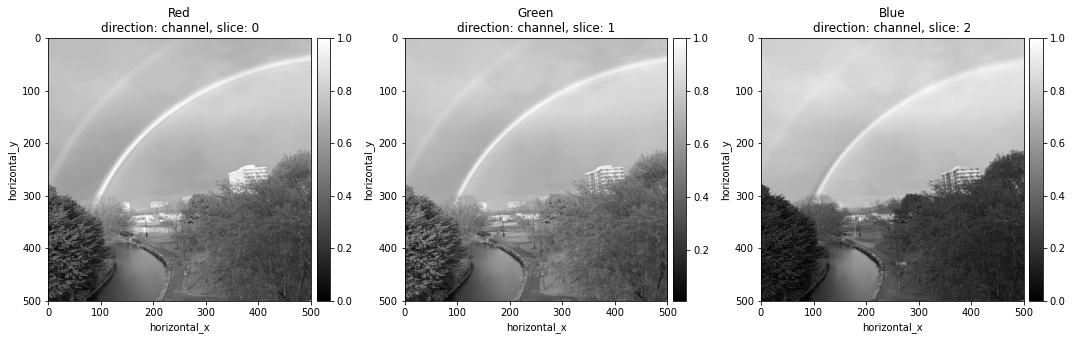

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(data.array)
plt.title("Colour Image")
plt.show()

show2D( data, slice_list=[('channel',0),('channel',1),('channel',2)], \
        title=["Red","Green","Blue"], origin="upper", num_cols=3)

<h1><center>Imaging Model </center></h1>

Let $u:\Omega\subset\mathbb{R}^{N\times M}\rightarrow\mathbb{R}^{N\times M\times3}$ a colour image that depicts a real _perfect_ scene (the unknown). Typically, we assume that $u$ has been transformed through a continuous and linear operation $\mathcal{L}$ (**forward operator**). Additionally, we have a noisy component $\eta$ that usually follows a certain distribution, e.g., **Gaussian** , **Salt and Pepper (Impluse)**. The **Imaging model** is defined as

<a id ="eq1"></a>
$$
\begin{equation}
u_{0} = \mathcal{L}u + \eta\,. 
\tag{1}
\end{equation}
$$

* **Image Denoising:** $\mathcal{L}$ is the Identity operator and we are trying to remove the noise from $u_{0}$ in order to reconstruct $u$.

<table><tr><td><img src='denoising_fig1.png'>
</td><td><img src='inpainting_fig2.png'></td></tr></table>

<a id ="chi_func"></a>
* **Image Inpainting:** $\mathcal{L}=\mathcal{X}_{\Omega\setminus D}$ is the characteristic function defined as 

    $$\mathcal{X}_{\Omega\setminus \mathcal{D}}(x) = 
    \begin{cases}
    1, & x\in \Omega\setminus D\\
    0, & \mbox{otherwise}
    \end{cases},
    $$
    
    where $\mathcal{D}$ is a subdomain of $\Omega$ (**inpainting domain**). In the inpainting domain there is no data information available and we are trying to reconstruct $u$ based on the information provided from the known region of $u_{0}$. 
    
<table><tr><td><img src='inpainting_fig1.png'>
</td><td><img src='inpainting_fig2.png'></td></tr></table>    

In this notebook, we will consider the cases of 

* denoising a noisy image corrupted by additive Gaussian noise,
* inpainting + denoising a noisy image corrupted by Salt \& Pepper noise with missing text information.

<h1><center>Color Denoising </center></h1>

We solve the following minimisation problem to denoise our coloured image:

<a id="rof"></a>
$$
\begin{equation}
u^{*} = \underset{u}{\operatorname{argmin}}  \frac{1}{2}\| b - u \|^{2}_{2} + \alpha\,\mathrm{VTV}(u)
\label{ROF}
\tag{1}
\end{equation},
$$

where the data $b$ is corrupted with Gaussian noise and $\mathrm{\textbf{VTV}}$ is the **Vectorial** extension of the classical Total variation regularisation for coloured images. We recall that the definition of the (isotropic) Total Variation, used for gray-valued images, is

$$
\mathrm{TV}(u) = \|Du\|_{2,1} = \sum_{i,j}^{M,N}\big(|(D_{y}u, D_{x}u)|_{2}\big)_{i,j} =  \sum_{i,j}^{M,N} \big(\sqrt{ (D_{y}u_{k})^{2} + (D_{x}u_{k})^{2}}\big)_{i,j}.
$$

Now, for vector-valued images the gradient is $Du=(Du_{1}, Du_{2}, Du_{3})$, where for each **RGB** channels $k=1,2,3$, $Du_{k}:=(D_{y}u_{k}, D_{x}u_{k})$. 

For this type of multichannel data, we can create different configurations on how the **colour channels**, the **derivatives** and the **image pixels** are correlated and under which norm. One generic approach for this regulariser is presented in [Duran et al](https://arxiv.org/pdf/1508.01308.pdf#page=8), where the **Collaborative Total variation** is introduced, i.e.,

$$
\|A\|_{p,q,r} := \bigg(\sum_{i=1}^{N}\quad\bigg(\sum_{j=1}^{M}\quad\bigg(\sum_{k=1}^{C} |A_{i,j,k}|^{p}\bigg)^{\frac{q}{p}}\quad\bigg)^{\frac{r}{q}}\quad\bigg)^{\frac{1}{r}}\quad .
$$

For simplicity, in this notebook, we will use the _Channelwise TV_ definition, namely, 

$$
\begin{equation}
\mathrm{VTV}(u)  := \|D u\|_{2,1}  = \sum_{k=1}^{3}\sum_{i,j=1}^{M,N} (|Du_{k}|_{2})_{i,j} = 
                 \sum_{k=1}^{3}\sum_{i,j=1}^{M,N} \big( \sqrt{ (D_{y}u_{k})^{2} + (D_{x}u_{k})^{2}}\big) = \sum_{k=1}^{3} \mathrm{TV}(u_{k}).
\label{tv_color}
\end{equation}
$$

The above definition corresponds to the $\ell_{2,1,1}$ (derivative, pixels, colour) Collaborative TV. This means that, an $\ell_{2}$ norm is applied for the **derivatives**, followed by an $\ell_{1}$ norm for the **pixels** of the image and a final $\ell_{1}$ norm for the three **channels**.

In [5]:
# Import Total variation
from cil.optimisation.functions import TotalVariation

## Load data and corrupt with gaussian noise

In [6]:
# Load Rainbow data
data = dataexample.RAINBOW.get(size=(500,500), scale=(0,1))
data.reorder(['horizontal_y', 'horizontal_x','channel'])

noisy_data = noise.gaussian(data, seed = 10, var = 0.005)

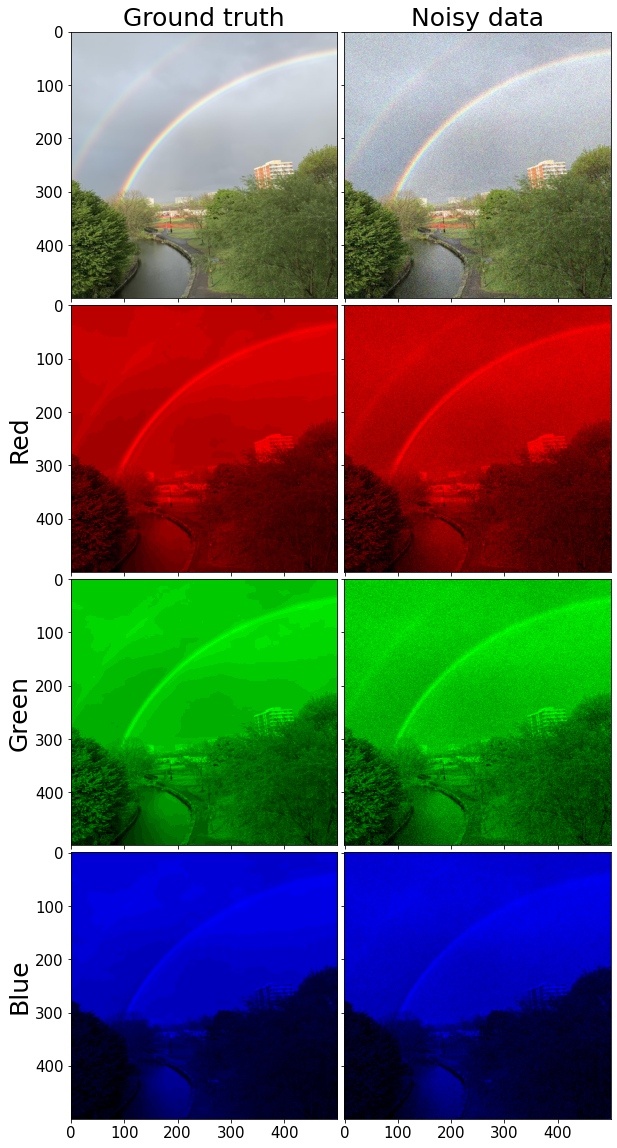

In [7]:
images = [data.as_array(), noisy_data.as_array(),
          data.as_array()[:,:,0], noisy_data.as_array()[:,:,0],
          data.as_array()[:,:,1], noisy_data.as_array()[:,:,1],
          data.as_array()[:,:,2], noisy_data.as_array()[:,:,2]]
          
#create our custom colour maps for RGB images
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm_r = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
colors = [(0, 0, 0), (0, 1, 0)] # first color is black, last is green
cm_g = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)
colors = [(0, 0, 0), (0, 0, 1)] # first color is black, last is blue
cm_b = LinearSegmentedColormap.from_list(
        "Custom", colors, N=20)

labels_y = ["Red", "Green","Blue"]
labels_x = ["Ground truth","Noisy data"]

# set fontszie xticks/yticks
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(20, 20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(4, 2),
                axes_pad=0.1,
                )

k = 0
for ax in grid:
    
    
    img = ax.imshow(images[k])
    if k==0 or k==1:
        ax.set_title(labels_x[k],fontsize=25)
    if k==2:
        ax.set_ylabel(labels_y[0],fontsize=25)
        img.set_cmap(cm_r)
    if k==3:
        img.set_cmap(cm_r)
    if k==4:
        ax.set_ylabel(labels_y[1],fontsize=25)
        img.set_cmap(cm_g)
    if k== 5:
        img.set_cmap(cm_g)
    if k==6:
        ax.set_ylabel(labels_y[2],fontsize=25)  
        img.set_cmap(cm_b)
    if k==7:
        img.set_cmap(cm_b)
    k+=1
        
plt.show()

We solve the above minimisation problem using the `proximal` method of the `TotalVariation` class that was used in previous notebooks. Recall, that given a function $f$, the _proximal operator of $f$_ is

$$\mathrm{prox}_{\tau f}(x) := \underset{u}{\operatorname{argmin}}\frac{1}{2}\|x-u\|_{2}^{2} + \tau f(u), \quad\mbox{for any } x.$$

This definition is exactly the same with the [above minimisation problem](#rof), if we replace $f$ by $\alpha\mathrm{VTV}$, $x$ with $b$ and $\tau=1.0$. Therefore, the _proximal operator of VTV at $b$_ is 

$$\mathrm{prox}_{\tau (\alpha \mathrm{VTV})}(b)\, .$$



In [8]:
alpha = 0.05
TV = alpha * TotalVariation(max_iteration=500)
proxTV = TV.proximal(noisy_data, tau=1.0)

/opt/SIRF-SuperBuild/INSTALL/python/cil/optimisation/operators/GradientOperator.py:93: UserWarning: Warning: correlation='Space' on multi-channel dataset will use `numpy` backend
  warnings.warn("Warning: correlation='Space' on multi-channel dataset will use `numpy` backend")


Initialised GradientOperator with numpy backend


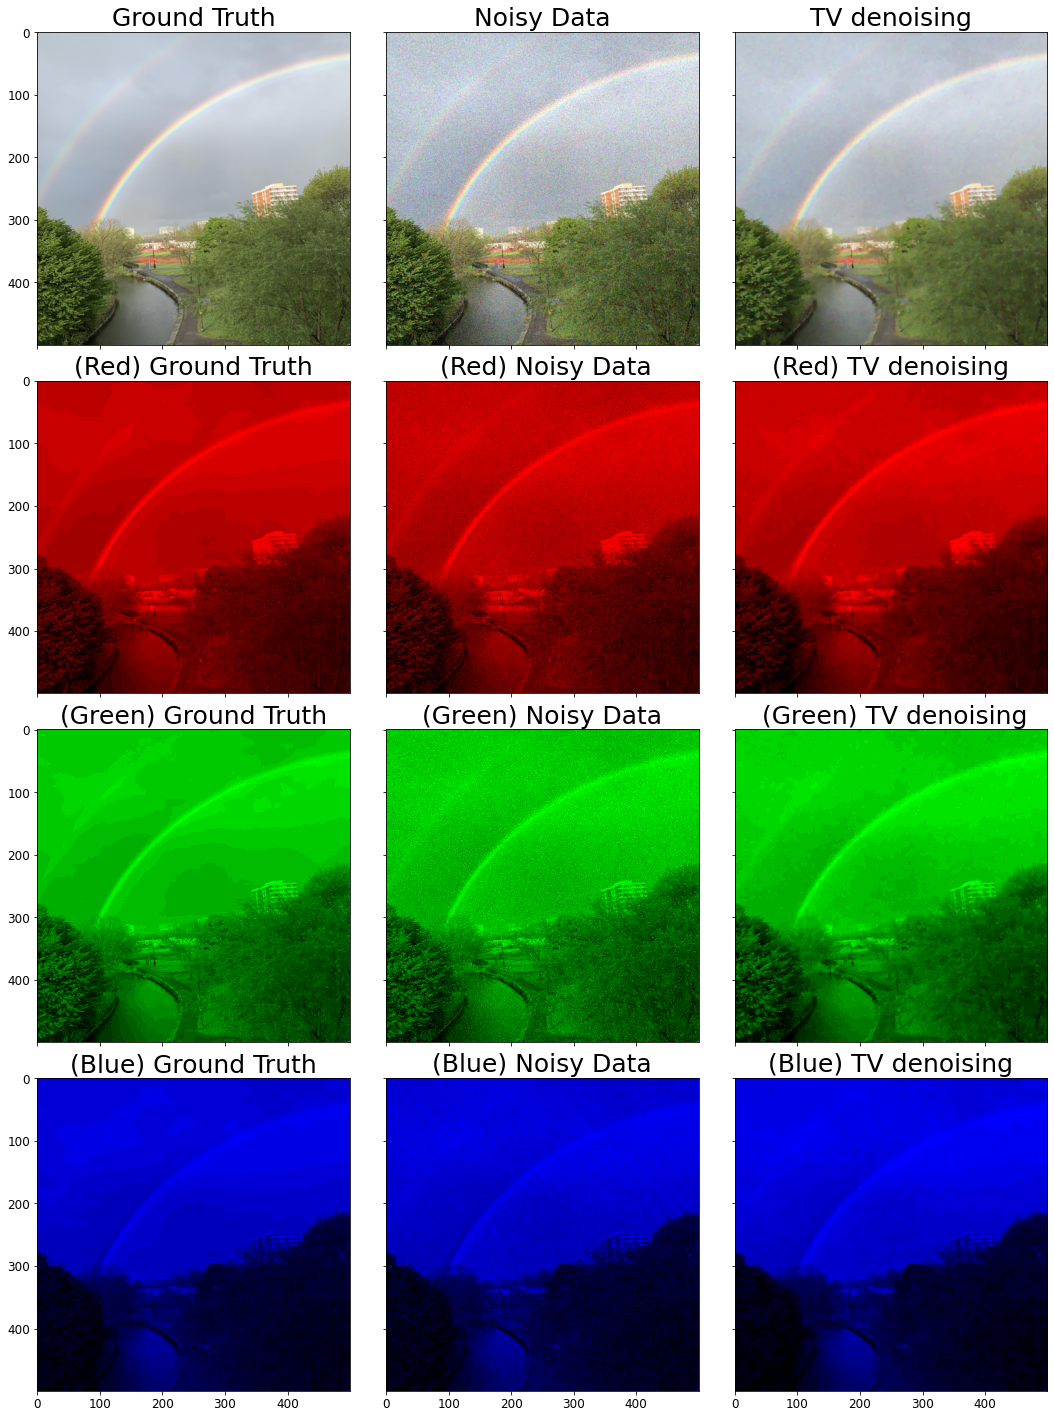

In [9]:
images = [data.as_array(), noisy_data.as_array(), proxTV.as_array(),
         data.as_array()[:,:,0], noisy_data.as_array()[:,:,0], proxTV.as_array()[:,:,0],
         data.as_array()[:,:,1], noisy_data.as_array()[:,:,1], proxTV.as_array()[:,:,1],
         data.as_array()[:,:,2], noisy_data.as_array()[:,:,2], proxTV.as_array()[:,:,2]],  
                             
labels_x = ["Ground Truth", "Noisy Data", "TV denoising",
           "(Red) Ground Truth", " (Red) Noisy Data", "(Red) TV denoising",
           "(Green) Ground Truth", "(Green) Noisy Data", " (Green) TV denoising",
           "(Blue) Ground Truth", "(Blue) Noisy Data", "(Blue) TV denoising"]

# set fontszie xticks/yticks
plt.rcParams['xtick.labelsize']=12
plt.rcParams['ytick.labelsize']=12

fig = plt.figure(figsize=(25, 25))

grid = AxesGrid(fig, 111,
                nrows_ncols=(4, 3),
                axes_pad=0.5,
                cbar_mode='None'
                )

k = 0
for ax in grid:
   
    img = ax.imshow(images[0][k])
    ax.set_title(labels_x[k],fontsize=25)
    if (k >= 9):
        img.set_cmap(cm_b)      
    elif (k >= 6):
        img.set_cmap(cm_g)
    elif (k >= 3):
        img.set_cmap(cm_r)    
    k+=1
    
cbar = ax.cax.colorbar(img)
plt.show()

## Exercise : Use the PDHG algorithm to solve the above problem

The triplet $(K, \mathcal{F}, \mathcal{G})$ is defined as:

* $K = D \Longleftrightarrow$ `K = GradientOperator(noisy_data.geometry)` .



* $\mathcal{F}(z) = \alpha\,\|z\|_{2,1}\Longleftrightarrow$ `F = alpha * MixedL21Norm()` .



* $\mathcal{G}(u) = \frac{1}{2}\|b - u \|^{2}_{2}\, \Longleftrightarrow$ `G = 0.5 * L2NormSquared(b=noisy_data)` .


<h1><center>Colour Inpainting </center></h1>

Given an image where a specific region is unknown, the task of image inpainting is to recover the missing region $\mathcal{D}$ from the known part of the image $\Omega$. For this example, we will use the _rainbow image_,  where we are trying to remove a repeated text (+ salt and pepper noise) from the image that represents the unknown domain $\mathcal{D}$.

## Create corrupted image

We use the *Pillow* library to add text in our image.

In [10]:
# Import libraries
import numpy as np
from PIL import Image, ImageFont, ImageDraw

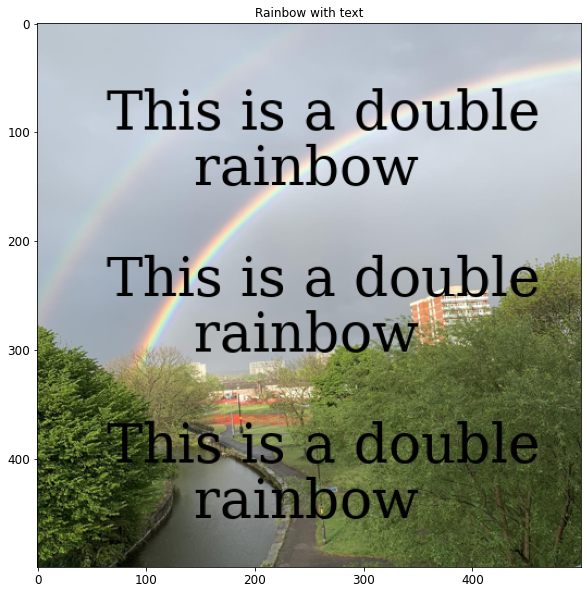

In [12]:
# Numpy array
img_np = data.array

# Add text to the image
img_pil = Image.fromarray(np.uint8(img_np*255)).convert('RGB')
text = "\n    This is a double \
        \n         rainbow \n"*3 

draw = ImageDraw.Draw(img_pil)
font = ImageFont.truetype('DejaVuSerif.ttf', 50)

draw.text((0, 0), text, (0, 0, 0), font=font)

# Pillow image to numpy
im1 = np.array(img_pil)

# Rescale numpy array
img_np_rescale = im1/im1.max()

# Get image geometry
ig = data.geometry

# Create ImageData
data_with_text = ig.allocate()
data_with_text.fill(img_np_rescale)

# Show rainbow with text
plt.figure(figsize=(10,10))
plt.imshow(data_with_text.array)
plt.title("Rainbow with text")
plt.show()

## Create the mask representing the $\mathcal{D}$ region

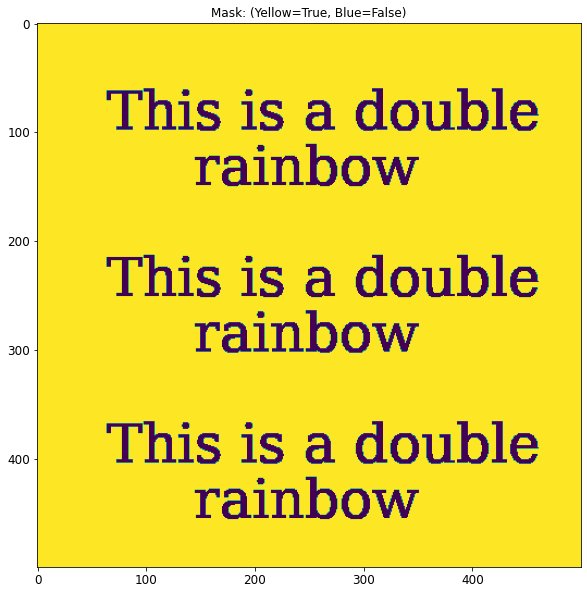

In [13]:
# Mask that contains only text information
mask_boolean = (data_with_text-data).abs()==0

# Show rainbow with text
plt.figure(figsize=(10,10))
plt.imshow(mask_boolean[:,:,0])
plt.title("Mask: (Yellow=True, Blue=False)")
plt.show()

## Apply the mask for the RGB channels

Our mask plays the role of the characteristic function defined [above](#chi_func). Here, we use the `MaskOperator` that applies a mask to our image for all the red, green and blue channels using the `ChannelwiseOperator`.

In [14]:
from cil.optimisation.operators import MaskOperator, ChannelwiseOperator

In [17]:
mask = ig.subset(channel=0).allocate()
mask.fill(mask_boolean[:,:,0])
MO = ChannelwiseOperator(MaskOperator(mask), 3, dimension = 'append')

## Add salt and pepper noise

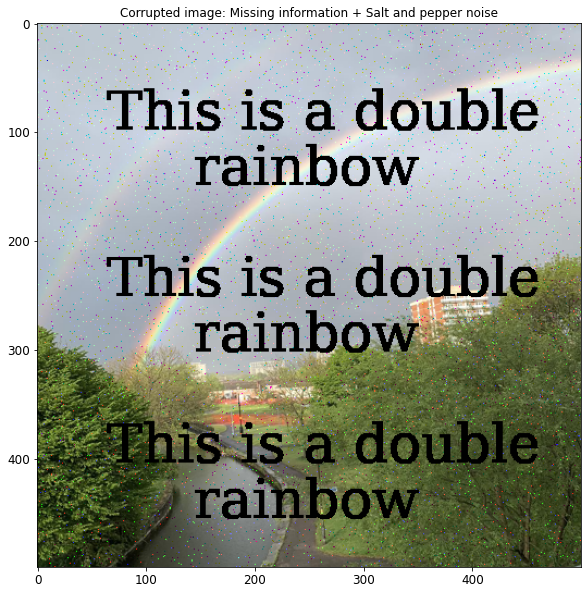

In [18]:
noisy_data = noise.saltnpepper(data_with_text, amount=0.01, seed = 10)
noisy_data = MO.direct(noisy_data) 

# noisy_data = MO.direct(data) 

plt.figure(figsize=(10,10))
plt.imshow(noisy_data.as_array())
plt.title("Corrupted image: Missing information + Salt and pepper noise")
plt.show()

## Total variation inpainting vs Total Generalised Variation

We will use two different regularisation in order to restore the above corrupted image. We start with the TV regularisation described above and its generalisation, namely the **Total Generalised Variation (TGV)** introduced in [Bredies et al](https://epubs.siam.org/doi/abs/10.1137/090769521?mobileUi=0). TGV is a higher-order regulariser, that is able to obtain piecewise smooth solutions and restore staircasing artifacts that TV promotes. We let $\alpha, \beta>0$ be two regularisation parameters and define

$$
\begin{equation}
\mathrm{TGV}_{\alpha, \beta}(u) = \min_{w} \alpha \|D u - w \|_{2,1} + \beta\|\mathcal{E}w\|_{2,1},
\label{TGV}
\end{equation}$$

where $\mathcal{E}$ denotes the **Symmetrised Gradient** operator defined as 

$$
\mathcal{E}w = \frac{1}{2}(D w + D w^{T}).
$$

The minimisation problems, using the $L^{1}$ norm as a data fidelity term which is suitable for salt & pepper noise, are:

$$
\begin{equation}
u^{*} =\underset{u}{\operatorname{argmin}} \|\mathcal{M}u-b\|_{1} + \alpha\mathrm{VTV}(u) 
\label{TV_L1_inpainting}
\tag{TV-$L^{1}$}
\end{equation}
$$

and 

<a id='TGV_L1'></a>
$$
\begin{equation}
\begin{aligned}
u^{*} =\underset{u}{\operatorname{argmin}} & \|\mathcal{M}u-b\|_{1} + \mathrm{TGV}_{\alpha, \beta}(u) \Leftrightarrow \\
(u^{*},w^{*}) =\underset{u, w}{\operatorname{argmin}} &  \|\mathcal{M}u -b\|_{1} + \alpha \|D u - w \|_{2,1} + \beta\|\mathcal{E}w\|_{2,1},
\end{aligned}
\label{TGV_L1_inpainting}
\tag{TGV-$L^{1}$}
\end{equation}
$$

where the $\mathcal{M}$ is a diagonal operator with 1 in the diagonal elements corresponding to pixels in $\Omega\setminus\mathcal{D}$ and 0 in $\mathcal{D}$.

We solve the above problems using the **PDHG** algorithm described in previous notebooks.

In [19]:
# Import libraries
from cil.optimisation.operators import BlockOperator, SymmetrisedGradientOperator, GradientOperator, ZeroOperator, IdentityOperator 
from cil.optimisation.functions import ZeroFunction, L1Norm, MixedL21Norm, BlockFunction, L2NormSquared
from cil.optimisation.algorithms import PDHG

## Setup and run the PDHG algorithm for $\mathrm{TV}-L^{1}$

In [ ]:
Grad = GradientOperator(ig)
K = BlockOperator(Grad, MO)

alpha_tv = 0.5
f1 = alpha_tv * MixedL21Norm()
f2 = L1Norm(b=noisy_data)
F = BlockFunction(f1, f2)

G = ZeroFunction()

pdhg_tv = PDHG(f=F,g=G,operator=K,
            max_iteration = 1000,
            update_objective_interval = 200)
pdhg_tv.run(verbose = 1)

Initialised GradientOperator with numpy backend
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.97609e+05


/opt/SIRF-SuperBuild/INSTALL/python/cil/framework/framework.py:2381: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      200       1000         0.047          1.54146e+04
      400       1000         0.047          1.47412e+04
      600       1000         0.047          1.46115e+04
      800       1000         0.048          1.45344e+04
     1000       1000         0.049          1.44563e+04
-------------------------------------------------------
     1000       1000         0.049          1.44563e+04
Stop criterion has been reached.



## Setup and run the PDHG algorithm for $\mathrm{TGV}-L^1$ 

Recall, that we need to define the triplet ($K$,  $\mathcal{F}$, $\mathcal{G}$) and write the above problem into the following form:

$$
\begin{equation}
u^{*} =\underset{u}{\operatorname{argmin}} \mathcal{F}(Ku) + \mathcal{G}(u).
\label{general_form}
\end{equation}
$$

Let $\textbf{u} = (u, w)\in \mathbb{X}$ and define an operator $K:\mathbb{X}\rightarrow\mathbb{Y}$ as

$$
\begin{equation}
K = 
\begin{bmatrix}
\mathcal{M} & \mathcal{O}\\
D & -\mathcal{I}\\
\mathcal{O} & \mathcal{E}
\end{bmatrix} \quad\Rightarrow\quad
K\textbf{u} = 
K \begin{bmatrix}
u\\
w
\end{bmatrix}=
\begin{bmatrix}
\mathcal{M}u\\
Du - w\\
\mathcal{E}w
\end{bmatrix} = 
\begin{bmatrix}
y_{1}\\
y_{2}\\
y_{3}
\end{bmatrix} = \textbf{y}\in \mathbb{Y},
\label{def_K}
\end{equation}
$$

where $\mathcal{O}$, $\mathcal{I}$ denote the zero and identity operators respectively.

For the function $\mathcal{F}$, we have that

$$
\begin{equation}
\begin{aligned}
& \mathcal{F}(\textbf{y})  := \mathcal{F}(y_{1}, y_{2}, y_{3}) = f_{1}(y_{1}) +  f_{2}(y_{2})  +  f_{3}(y_{3}), \mbox{ where},\\
& f_{1}(y_{1}) :=  \| y_{1} - b\|_1,\, f_{2}(y_{2}) :=  \alpha \|y_{2}\|_{2,1},\, f_{3}(y_{3}) := \beta\|y_{3}\|_{2,1},
\end{aligned}
\label{def_f}
\end{equation} 
$$

and for the function $\mathcal{G}$, $\mathcal{G}(\textbf{u}) = \mathcal{G}(u,w) = O(u)\equiv 0 $ is the zero function. 

We conclude that

$$
\begin{equation*}
\begin{aligned}
f(K\textbf{u}) + g(\textbf{u}) & = f\bigg(\begin{bmatrix}
\mathcal{M}u\\
Du - w\\
\mathcal{E}w
\end{bmatrix}\bigg)  = f_{1}(\mathcal{M}u) + f_{2}(Du-w) + f_{3}(\mathcal{E}w) \\
& = \|\mathcal{M}u -b\|_{1} + \alpha \|D u - w \|_{2,1} + \beta\|\mathcal{E}w\|_{2,1},
\end{aligned}
\end{equation*}
$$

which is exactly the objective function in [TGV_L1](#TGV_L1). 


In [ ]:
# Regularisation parameters
alpha_tgv = 0.4
beta_tgv = 0.2

# Define BlockOperator K
K11 = MO
K21 = Grad
K32 = SymmetrisedGradientOperator(K21.range)
K12 = ZeroOperator(K32.domain, ig)
K22 = IdentityOperator(K21.range)
K31 = ZeroOperator(ig, K32.range)
K = BlockOperator(K11, K12, K21, -K22, K31, K32, shape=(3,2) )

# Define BlockFunction f
f2 = alpha_tgv * MixedL21Norm()
f3 = beta_tgv * MixedL21Norm() 
f1 = L1Norm(b=noisy_data)

F = BlockFunction(f1, f2, f3) 

# Setup and run the PDHG algorithm
pdhg_tgv = PDHG(f=F,g=G,operator=K,
            max_iteration = 2000,
            update_objective_interval = 200)
pdhg_tgv.run(verbose = 1)

PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       2000         0.000          3.97609e+05
      200       2000         0.147          1.29000e+04
      400       2000         0.147          1.17320e+04
      600       2000         0.145          1.15007e+04
      800       2000         0.144          1.13345e+04
     1000       2000         0.144          1.12124e+04
     1200       2000         0.144          1.11511e+04
     1400       2000         0.144          1.11071e+04
     1600       2000         0.143          1.10773e+04
     1800       2000         0.143          1.10543e+04


In [ ]:
images = [data, pdhg_tv.solution, (pdhg_tv.solution-data).abs()*3,
          noisy_data, pdhg_tgv.solution[0], (pdhg_tgv.solution[0]-data).abs()*3],  
                             
labels_x = ["Ground Truth", "TV inpainting/denoising", " |Ground Truth - TV|", 
            "Corrupted Image", "TGV inpainting/denoising", " |Ground Truth - TGV|"]

# set fontszie xticks/yticks
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

fig = plt.figure(figsize=(20, 20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(2, 3),
                axes_pad=0.8,
                cbar_mode='single',
                cbar_location='bottom',
                cbar_size = 0.5,
                cbar_pad=0.3
                )

k = 0
for ax in grid:
        
    img = ax.imshow(images[0][k].as_array())
    ax.set_title(labels_x[k],fontsize=25)
    k+=1
    
cbar = ax.cax.colorbar(img)
plt.show()

<h1><center>Conclusions</center></h1>

In this notebook, we presented how to reconstruct multichannel data with 3 channels, using two different regularisers and data fitting terms. The following notebooks will demonstrate how to reconstruct multichannel data for CT and MRI applications:

* **Dynamic CT**: Channels contain temporal information from the acquisition data.
* **Hypespectral CT**: Channels contain spectral energy information acquired from an energy-sensitive X-ray detector.
* **Sequence MRI**: Channels contain information from two MR images with different contrast.
